# Analysis
Analysis the data and find features that can be used to predict the target variable.

In [2]:
import lakeapi
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import cufflinks

from statsmodels.api import OLS
from statsmodels.tsa.stattools import adfuller

lakeapi.use_sample_data(anonymous_access=True)
cufflinks.go_offline()

*Parameters*

In [3]:
HORIZONS = np.linspace(10, 10000, 50)
TRAIN_SIZE = 0.7

## Initialisation
Load the data from the input files, add some useful columns. Creation of the return at different horizons.

In [4]:
# Load data
books = lakeapi.load_data(
    table="book",
    start=datetime.datetime(2022, 10, 1),
    end=datetime.datetime(2022, 10, 2),
    symbols=["BTC-USDT"],
    exchanges=["BINANCE"],
)

tick_val = books["received_time"].diff().mean() / pd.Timedelta(seconds=1)  # seconds

books["mid_price"] = (books["ask_0_price"] + books["bid_0_price"]) / 2
books["spread"] = books["ask_0_price"] - books["bid_0_price"]


### Target variable

In [5]:
# Target creation

targets = pd.DataFrame()
for x in HORIZONS:
    targets[f"return_{x}"] = books["mid_price"].diff(x) / books["mid_price"]
books = pd.concat([books, targets], axis=1)
del targets

#  split data in train and test
books["set"] = ["train"] * int(np.floor(TRAIN_SIZE * len(books))) + ["test"] * int(
    np.ceil((1 - TRAIN_SIZE) * len(books))
)

### Stationarity
The Dickey-Fuller test is a statistical test used to determine whether a given time series is stationary or non-stationary.

In [6]:
# Test the stationarity of the time series
def adf_test(timeseries):

    dftest = adfuller(timeseries)
    return (
        "stationnary" if dftest[1] < 0.05 else "non-stationnary", dftest[1]
    )

# reduce the size of the dataset for memory issues (1/8 of the dataset)
start = np.random.randint(0, len(books) - 100000)
sample = books.iloc[start : start + 100000]

print("ADF test for returns")
for x in [0, len(HORIZONS) // 2, -1]:
    print(adf_test(sample[f"return_{HORIZONS[x]}"].dropna()))


ADF test for returns
('stationnary', 0.0)
('stationnary', 0.011956148887090729)
('non-stationnary', 0.06860698606838585)
ADF test for dspread
('stationnary', 0.0)
('stationnary', 0.0)
('stationnary', 0.0)


## Features

In [25]:
def prediction_stat(y_col: str, X_col: list[str]):

    def success_ratio(y, yhat):
        return np.mean(np.sign(y) == np.sign(yhat))

    data = books.dropna(
        subset=X_col + ["set"] + [y_col], how="any"
    )

    if len(X_col) == 1:
        X_train = data.loc[data["set"] == "train", X_col].values.reshape(-1, 1)
        X_test = data.loc[data["set"] == "test", X_col].values.reshape(-1, 1)

    else:
        X_train = data.loc[data["set"] == "train", X_col].values
        X_test = data.loc[data["set"] == "test", X_col].values

    y_train = data.loc[data["set"] == "train", y_col].values
    y_test = data.loc[data["set"] == "test", y_col].values

    model = OLS(y_train, X_train)
    results = model.fit()

    predictions = results.predict(X_test)

    success = success_ratio(y_test, predictions)

    return (
        1
        - np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2),
        success,
    )


def plot_stat(x_col: str, y_col:str, R2: pd.DataFrame, success_ratios: pd.DataFrame):

    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=("Out of sample R2", "Success Ratio"),
        shared_xaxes=True,
    )
    fig.add_trace(
        px.line(
            x=[tick_val * horizon for horizon in HORIZONS],
            y=R2[x_col],
        ).data[0],
        row=1,
        col=1,
    )
    fig.add_hline(
        y=0,
        line_dash="dot",
        row=1,
        col=1,
    )
    fig.add_trace(
        px.line(
            x=[tick_val * horizon for horizon in HORIZONS],
            y=success_ratios[x_col],
        ).data[0],
        row=2,
        col=1,
    )
    fig.add_hline(
        y=0.5,
        line_dash="dot",
        row=2,
        col=1,
    )
    fig.update_layout(
        showlegend=False,
        title_text=f"Prediction of {y_col} with {x_col}",
        template="plotly_dark",
    )
    fig.update_xaxes(title_text="Horizon (s)", row=2, col=1)
    fig.show()


def plot_corr(x_col:str, corr_return: pd.Series, corr_spread: pd.Series):

    # Creating the matplotlib figure and subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting correlation between spread and return
    axs[0].plot(corr_return.index * tick_val, corr_return)
    axs[0].set_title(f'Correlation between return and {x_col}')
    axs[0].set_ylabel("Correlation")
    axs[0].grid()

    # Plotting correlation between spread and dspread
    axs[1].plot(corr_spread.index * tick_val, corr_spread)
    axs[1].set_title(f'Correlation between spread and {x_col}')
    axs[1].set_xlabel(f'Time')
    axs[1].set_ylabel('Correlation')
    axs[1].grid()

    # Adjusting layout
    plt.tight_layout()
    plt.suptitle('Correlation Plots', y=1.02)  # Title for the whole figure
    plt.subplots_adjust(hspace=0.3)  # Adjust vertical space between subplots

    # Display the plot
    plt.show()





R2_return = pd.DataFrame({"target": HORIZONS})
R2_return.set_index("target", inplace=True)
success_ratios_return = pd.DataFrame({"target": HORIZONS})
success_ratios_return.set_index("target", inplace=True)

### Spread
The spread is the difference between the best ask price and the best bid price. The spread is a measure of the liquidity of the market. A low spread indicates that the market is liquid, while a high spread indicates that the market is illiquid.

$$
\text{Spread} = \text{Best Ask Price} - \text{Best Bid Price}
$$

<Axes: title={'center': 'Correlation between spread and return'}>

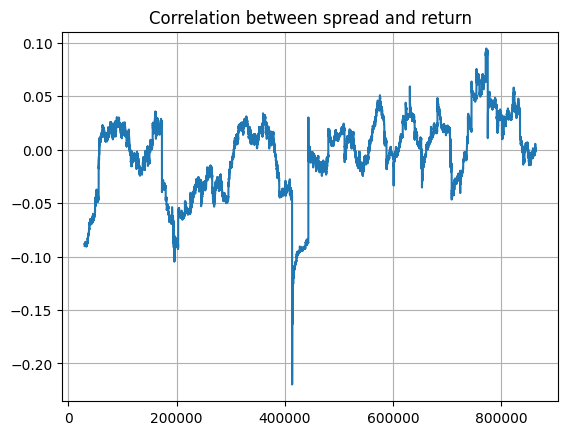

In [27]:
books["spread"].rolling(30000).corr(books[f"return_{HORIZONS[0]}"]).dropna().plot( title="Correlation between spread and return", grid=True)

In [49]:
# Calculate R2 and success ratio
for x in HORIZONS:
    r2, success = prediction_stat(f"return_{x}", ["spread"])
    R2_return.loc[x, "Spread"] = r2
    success_ratios_return.loc[x, "Spread"] = success

# Plot
plot_stat("Spread", "return", R2_return, success_ratios_return)

### Book Imbalance
The book imbalance is a feature that is often used in the literature to predict the price movement. The book imbalance is calculated as follows:

$$
\text{Book Imbalance} = \frac{\text{Total Bids} - \text{Total Asks}}{\text{Total Bids} + \text{Total Asks}}
$$

The value of the book imbalance belongs to [-1, 1]


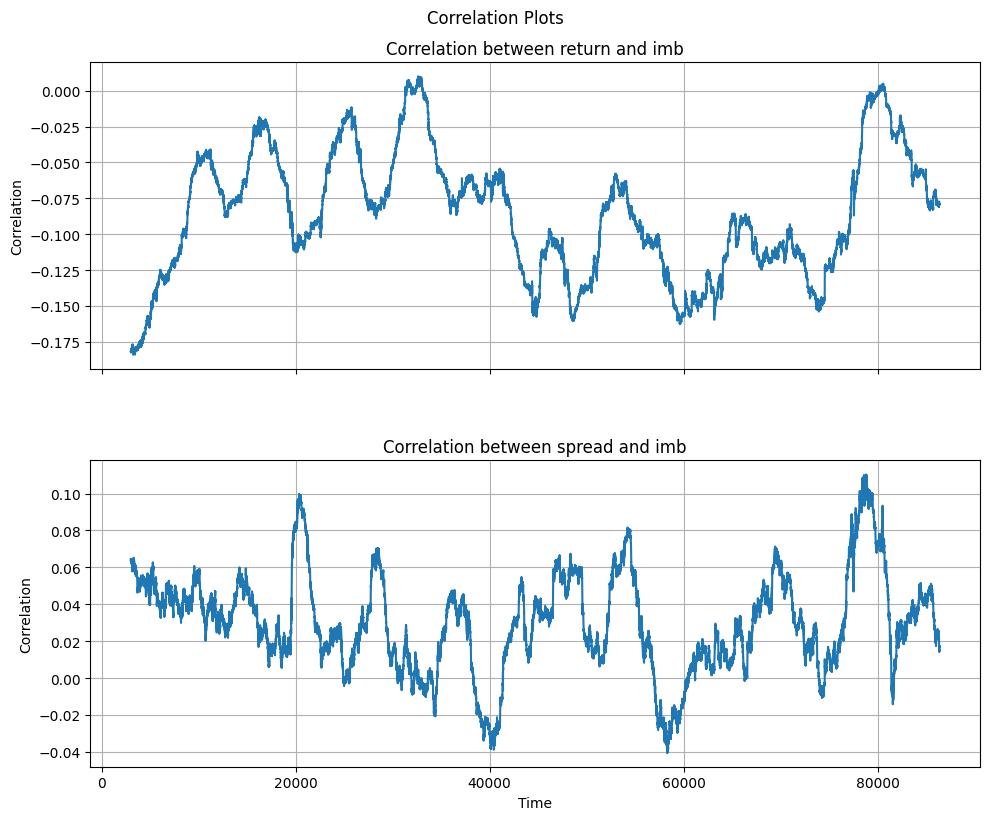

In [29]:
# Book imbalance calculation
asks_size = books.filter(regex="ask_[0-9]+_size")
bids_size = books.filter(regex="bid_[0-9]+_size")

bids_size = np.sum(bids_size, axis=1)
asks_size = np.sum(asks_size, axis=1)

books["imb"] = (asks_size - bids_size) / (asks_size + bids_size)


plot_corr("imb", books["imb"].rolling(30000).corr(books[f"return_{HORIZONS[0]}"]).dropna(), books["imb"].rolling(30000).corr(books["spread"]).dropna())

In [31]:
# Calculate R2 and success ratio
for x in HORIZONS:
    r2, success = prediction_stat(f"return_{x}", ["imb"])
    R2_return.loc[x, "Imbalance ratio"] = r2
    success_ratios_return.loc[x, "Imbalance ratio"] = success

# Plot
plot_stat("Imbalance ratio", "return", R2_return, success_ratios_return)

### Volatility
The volatility is a measure of the dispersion of the returns. The volatility is calculated as the standard deviation of the returns for 300 ticks.

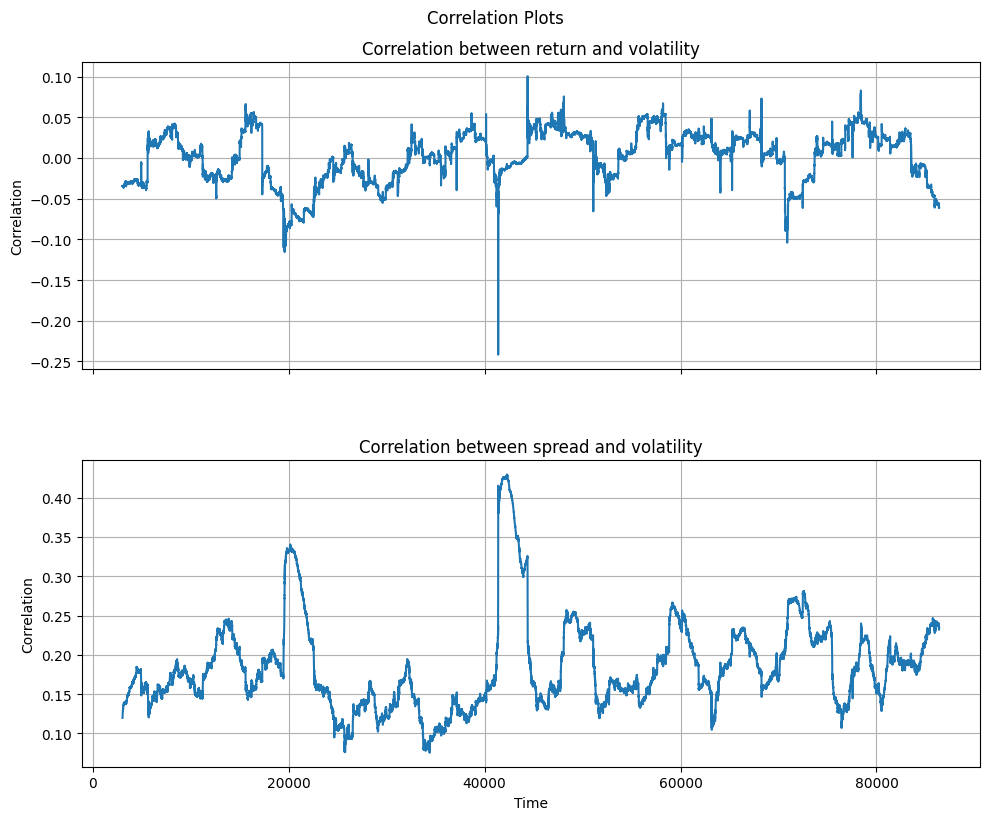

In [28]:
# Volatility calculation over 300 ticks The volatility is calculated as the standard deviation of the returns for 300 ticks.
books["volatility"] = (books["mid_price"].diff()/ books["mid_price"]).rolling(300).std()

plot_corr("volatility", books["volatility"].rolling(30000).corr(books[f"return_{HORIZONS[0]}"]).dropna(), books["volatility"].rolling(30000).corr(books["spread"]).dropna())


In [33]:
# Calculate R2 and success ratio
for x in HORIZONS:
    r2, success = prediction_stat(f"return_{x}", ["volatility"])
    R2_return.loc[x, "Volatility"] = r2
    success_ratios_return.loc[x, "Volatility"] = success

# Plot
plot_stat("Volatility", "return", R2_return, success_ratios_return)

### RSI (Relative Strength Index)
The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. The RSI oscillates between 0 and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.

$$
\text{RSI} = 100 - \frac{100}{1 + \text{RS}}
$$
where RS is the EMA of the number of days the stock closes up divided by the number of days the stock closes down.
$$
\text{RS} = \frac{\text{Average}(n, \text{Close Up})}{| \text{Average}(n, \text{Close Down})| }
$$


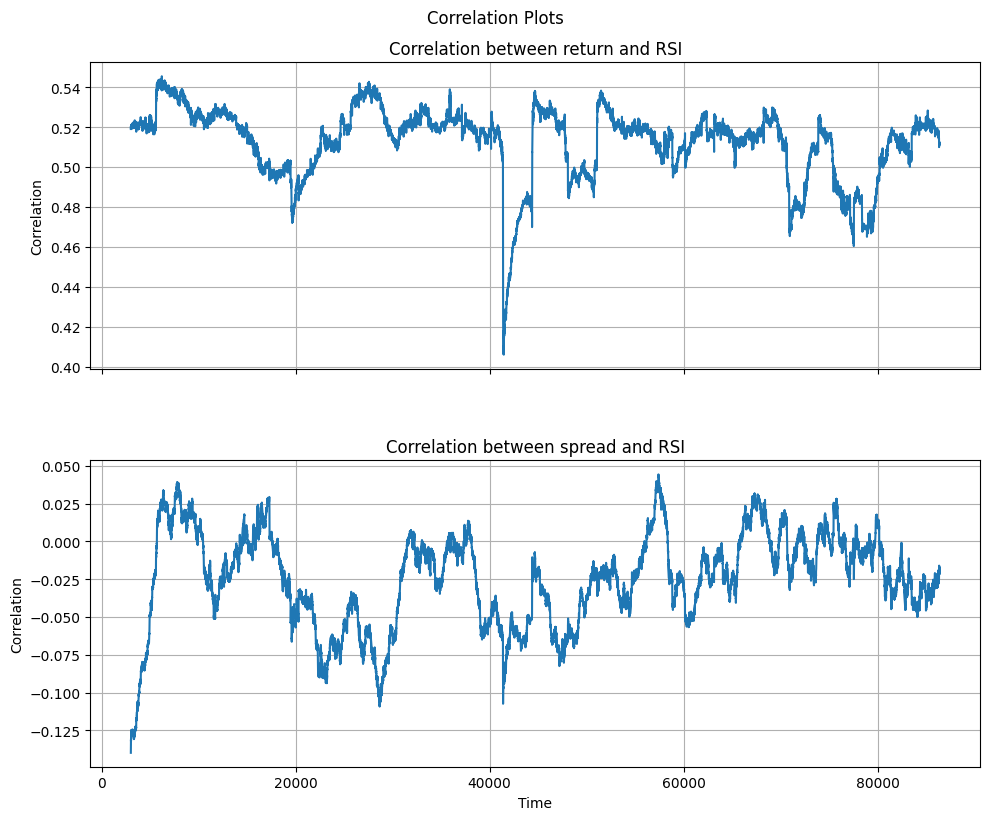

In [31]:
# RSI calculation
n = 100
books["rsi"] = 100 - 100 / (
    1
    + books["mid_price"].diff().clip(lower=0).ewm(span=n).mean()
    / abs(books["mid_price"].diff().clip(upper=0).ewm(span=n).mean())
)

plot_corr("RSI", books["rsi"].rolling(30000).corr(books[f"return_{HORIZONS[0]}"]).dropna(), books["rsi"].rolling(30000).corr(books["spread"]).dropna())

In [66]:
# Calculate R2 and success ratio
for x in HORIZONS:
    r2, success = prediction_stat(f"return_{x}", ["rsi"])
    R2_return.loc[x, "RSI"] = r2
    success_ratios_return.loc[x, "RSI"] = success

# Plot
plot_stat("RSI", "return", R2_return, success_ratios_return)